# SHapley Additive exPlanations

SHapley Additive exPlanations (SHAP) is a framework for explaining the output of machine learning models. It is based on Shapley values, a concept from cooperative game theory that assigns a value to each player in a coalition based on their marginal contributions to the end-goal of the game. In the context of machine learning, SHAP values provide a way to fairly distribute the contribution of each feature to the prediction of a model (classification or regression). They help interpret the model's output, offering insights into the importance and impact of individual features on the model's decision.

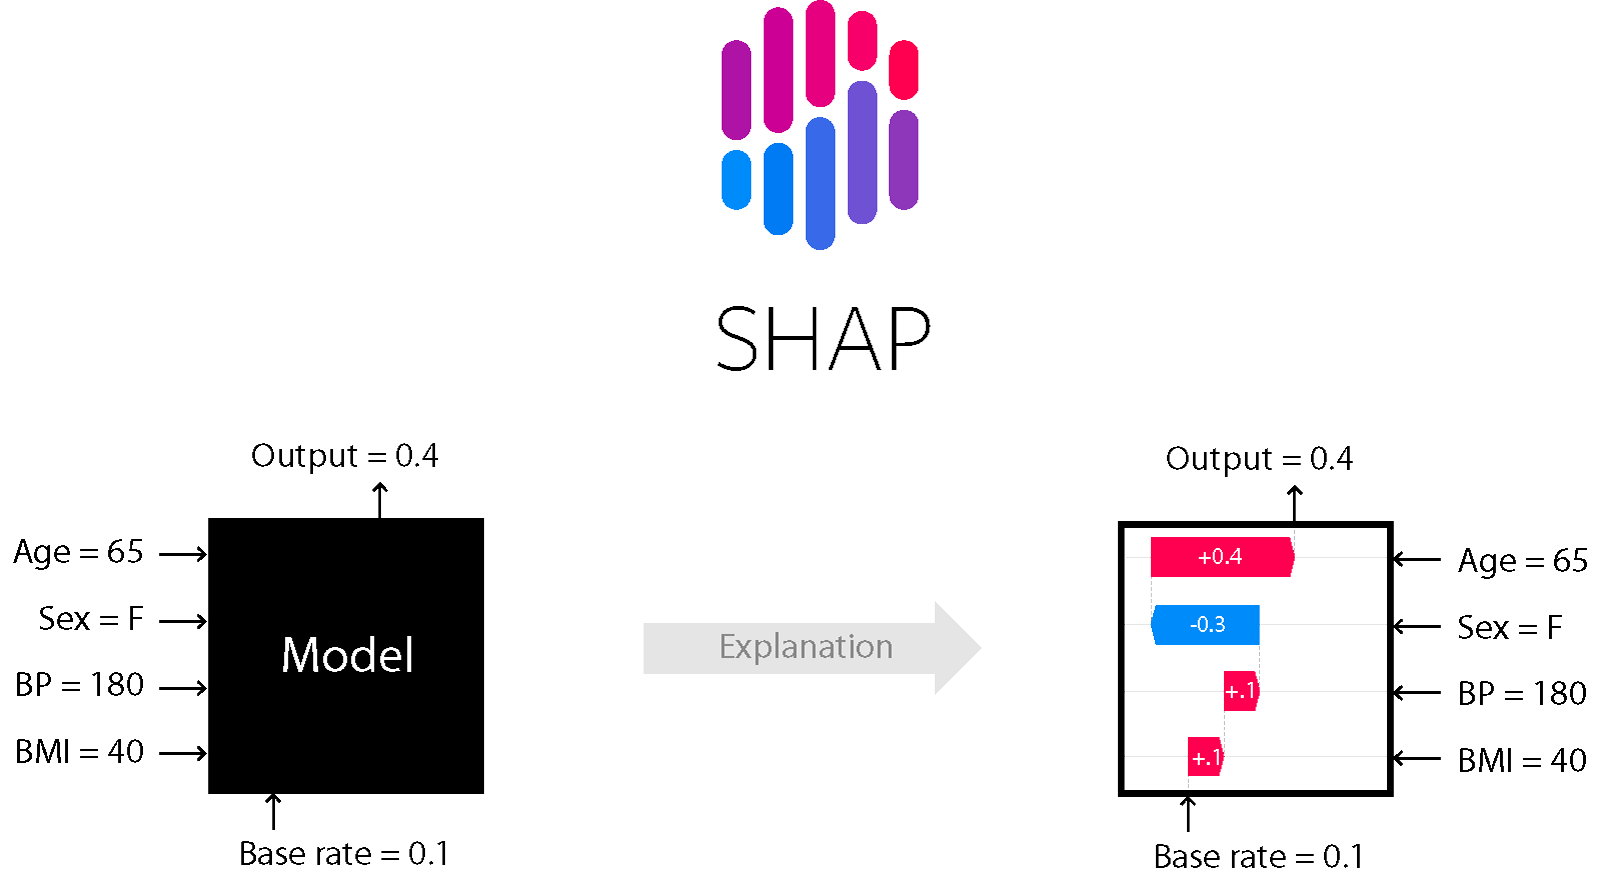

Source: https://shap.readthedocs.io/en/latest/#

The Shapley value is calculated by considering all possible combinations of features and determining the average contribution of a particular feature across all possible combinations.

Here's a simplified explanation of how it works:
1. **All Possible Combinations**: For each prediction, all possible combinations of features are considered, ranging from subsets with only one feature to the full set of features.
2. **Contribution Calculation**: The contribution of a feature is calculated for each combination by comparing the model's prediction with and without that specific feature.
3. **Weighted Average**: Shapley values are obtained by taking the average contribution of a feature across all combinations.
4. **Interpretation**: Positive Shapley values indicate how much a feature contributes to the positive class prediction, while negative values represent the contribution to the negative class prediction.

In summary, SHAP provides a way to distribute the model's prediction among its input features fairly, helping to understand the importance of each feature in the overall decision-making process.

## Settings

In [77]:
# import python packages
import shap
import pickle
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

In [78]:
# allow multiple outputs of a cell to be displayed

In [79]:
'A'
'B'

'A'

'B'

In [80]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [81]:
'A'
'B'

'A'

'B'

## Data set

We are going to continue to follow this paper: \
"A Prediction Model to Prioritize Individuals for a SARS-CoV-2 Test Built from National Symptom Surveys" by Shoer et al.,\
Cell Med https://doi.org/10.1016/j.medj.2020.10.002.

**Introduction**\
The rapid and global spread of COVID-19 led the World Health Organization (WHO) to declare it a pandemic on March 11, 2020. One major factor that contributed to the spread of the virus is the apparently large number of undiagnosed infected individuals. This knowledge gap facilitates the silent propagation of the virus, delays the response of public health officials, and results in an explosion in the number of cases.

One reason for this knowledge gap in the early days of the pandamic was insufficient testing. While the gold standard for COVID-19 diagnosis is detection of viral RNA in a reverse transcription PCR test, the number of tests was limited. In a time when almost all countries were faced with the same health challenge, resources were scarce. This created the need for a prioritization mechanism to allocate tests and resources more efficiently toward individuals who are more likely to test positive, leading to earlier identification of COVID-19 patients, social isolation, and reduced spread of the virus.

The paper presents a model that provides estimates of the probability of an individual to test positive for SARS-CoV-2 infection in a PCR test, based on a national symptom survey that was distributed in Israel. Using the model, the risk for a positive COVID-19 test can be evaluated in less than a minute and without added costs or risk of exposure to a suspected patient. This approach was used to make more efficient use of available testing capacities, by significantly increasing the fraction of positive tests obtained, and by rapidly identifying individuals that should be isolated until definitive test results are obtained.

The **goal** of this tutorial is to re-create such model using Gradient Boosting Decision Trees (part 1), and to gain insight into the features that contribute most to the predicted probability of being diagnosed with COVID-19 (part 2).

In [82]:
# copy the model from the first section of the tutorial to your local directory
!cp /home/projects/aihubadm/aihub_shared/ex-trees-shap/model.pkl .

# and the data as it was used to train the model
!cp /home/projects/aihubadm/aihub_shared/ex-trees-shap/data_clean.csv .

In [83]:
# load the model 
model = pickle.load(open('model.pkl', 'rb'))

# and the data
df = pd.read_csv('data_clean.csv', index_col=0)

In [84]:
# Look at the data:
df
model

,age,gender,smell_or_taste_loss,shortness_of_breath,sore_throat,cough,fever,feel_well,prior_medical_condition,covid
0,75,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
29075,65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29076,55,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
29077,45,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
29078,55,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
33819,45,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
10688,35,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
23138,65,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
7403,65,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [85]:
# Create an "only features" table (X)
X = df.iloc[:, 0:9]
X

,age,gender,smell_or_taste_loss,shortness_of_breath,sore_throat,cough,fever,feel_well,prior_medical_condition
0,75,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
29075,65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29076,55,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
29077,45,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
29078,55,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
33819,45,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
10688,35,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
23138,65,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
7403,65,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


## Decipher the model

The SHAP value for a particular sample and feature represents their marginal contribution to the prediction. In other words, it quantifies how much the inclusion of a particular feature influences the model's output for that specific sample.

A positive SHAP value for a feature indicates that the feature value contributes to the positive prediction of the model for the given instance. Conversely, a negative SHAP value suggests contribution to the negative prediction.

The absolute of the SHAP value represents the overall importance of the feature for a specific prediction. Larger absolute SHAP values indicate a greater influence of the corresponding feature on the model's output.

Compute the SHAP value for every feature and instance in the dataset and save them in a variable\
https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/heatmap.html

In [86]:
# compute SHAP values by the model agnostic "Explainer" method:
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

100%|===================| 43542/43752 [01:54<00:00]        

Look at the SHAP values dimensions, what do the rows and columns represnt?

In [87]:
shap_values.shape

(43752, 9)

#### The rows represent instances, and the cols represent the 9 features, which means that for every sample, every feature is given a SHAP value. We can know, for every instance's prediction, what the most and least influential features were and in which direction (having covid or not).

Plot the SHAP values for a thousand random samples (otherwise it takes a long time)
https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/heatmap.html

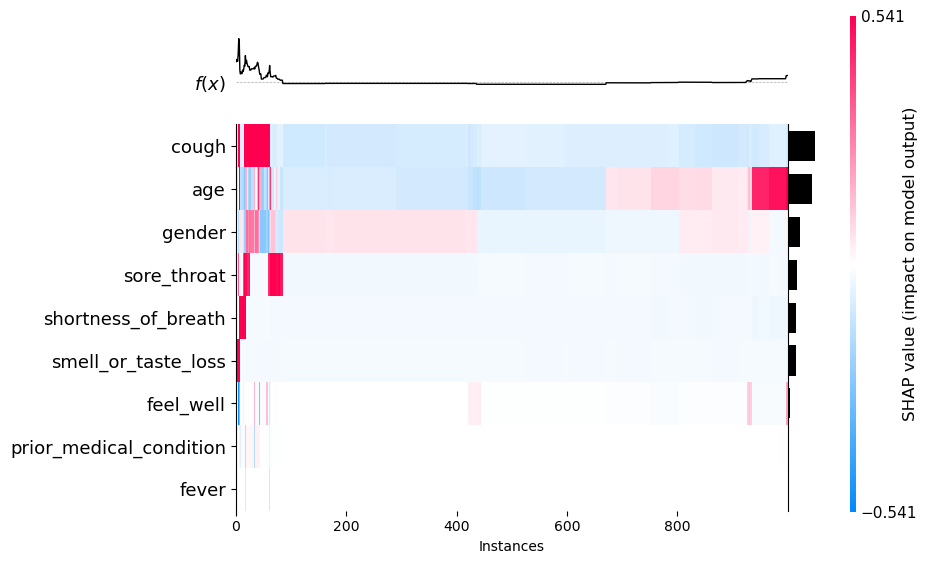

In [88]:
# Randomly sample 1000 indices from the SHAP values:
np.random.seed(42) # for reproducability
sample_indices = np.random.choice(shap_values.shape[0], size=1000, replace=False)

# Sample the SHAP values using the selected indices:
shap_values_sampled = shap_values[sample_indices]

# Plot the heatmap using the sampled SHAP values:
shap.plots.heatmap(shap_values_sampled)

What is f(x)?

In [89]:
# see what the base_value is (the horizontal line in f(x) representation:
shap_values_sampled.base_values[1:10]

array([-4.44267417, -4.44267417, -4.44267417, -4.44267417, -4.44267417,
       -4.44267417, -4.44267417, -4.44267417, -4.44267417])

#### f(x) is the prediction for every sample (the output of the model), basically calculated by the baseline prediction plus the SHAP values themselves. In our example, the prediction is whether the patients had covid or not (0/1). The function is represented relative to an averaged output of the model (horizontal line), without taking into account the different features.

What are the bars to the right of the heatmap?

#### The bars to the right represent the overall contribution of each feature to the model.

What does the color indicate?

#### These are the SHAP values which are the impact on of a feature per instace to the model's output! 
#### Red shapley values represent how much a feature contributes to the having a positive prediction (having covid in our case) and the blue represents the opposite (being classified as not having covid).

## Feature importance

Plot the SHAP values just for the first sample\
https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/bar.html

In [90]:
# Take a look at the SHAP values for 1st instance:
shap_values[0]

.values =
array([ 5.00979885e-01, -2.56500682e-02, -2.39969051e-02, -3.58989142e-02,
       -2.41946523e-02, -6.95737342e-02,  0.00000000e+00, -1.98571426e-02,
       -3.11370359e-04])

.base_values =
-4.44267417087834

.data =
array([75.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.])

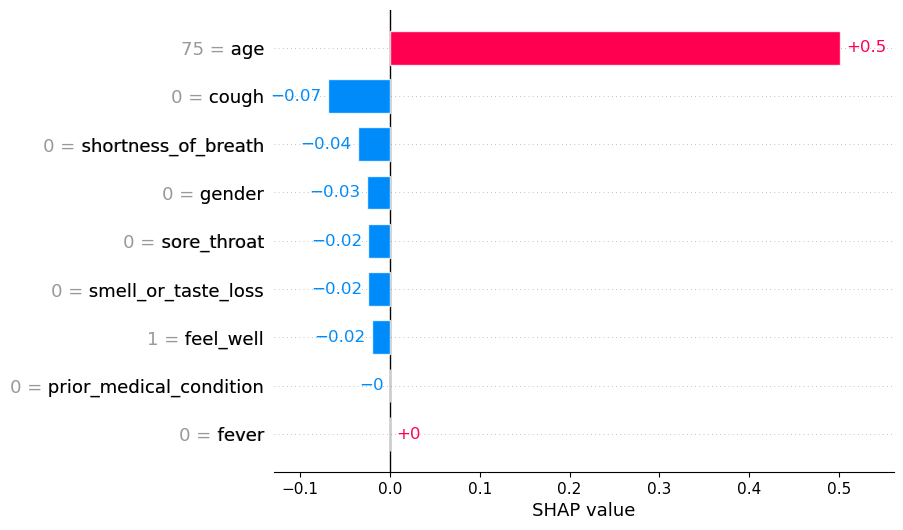

In [91]:
# Plot:
shap.plots.bar(shap_values[0], show_data= True)

What are the numbers next to the bars?

#### The shapely values - what's the contribution of this feature in this instance to the model's prediction.

What are the numbers next to the feature names?

#### The actual values of each feature for this specific sample.

How old is this person?

#### 75.

In what scenarios might the interpretation of SHAP values become ambiguous or less reliable, and how can practitioners mitigate such challenges?

#### When interactions between features are present, interpreting SHAP values can become challenging. For example, if two features are **highly correlated**, SHAP values may struggle to reveal this, as they aim to estimate each feature’s independent contribution to the model's output. One way to address this is by performing feature selection to remove one of the highly correlated features before applying SHAP.
#### Similarly, **feature dependencies** can complicate SHAP interpretations, as contributions may not be accurately represented for individual features. To handle this, practitioners can experiment with grouping or transforming features so that SHAP values can reflect the combined effect of interdependent features.

Based on the SHAP values, compute the model's prediction for the first instance

In [92]:
# Look at the data:
df.iloc[0]
shap_values[0].values
shap_values[0].base_values

age                        75.0
gender                      0.0
smell_or_taste_loss         0.0
shortness_of_breath         0.0
sore_throat                 0.0
cough                       0.0
fever                       0.0
feel_well                   1.0
prior_medical_condition     0.0
covid                       0.0
Name: 0, dtype: float64

array([ 5.00979885e-01, -2.56500682e-02, -2.39969051e-02, -3.58989142e-02,
       -2.41946523e-02, -6.95737342e-02,  0.00000000e+00, -1.98571426e-02,
       -3.11370359e-04])

-4.44267417087834

In [93]:
print(f"The model's prediction for the first instance is: {np.sum(shap_values[0].values)+shap_values[0].base_values}")

The model's prediction for the first instance is: -4.141177073079702


Hint: if the scales do not match, look at the model_output parameter in the shap.TreeExplainer, it can be used in the shap.Explainer as well \
https://shap.readthedocs.io/en/latest/generated/shap.TreeExplainer.html

In [94]:
explainer.model_output

'raw'

#### The prediction should be binary 0/1, but since the model's output is "raw" it means that is gives the prediction without any transformation before. For binary classification in XGBoost, this is the log odds ratio.

In [95]:
# to get the binary classification I need to apply sigmoid function:
raw_output=np.sum(shap_values[0].values)+shap_values[0].base_values
# Apply sigmoid function to get the probability:
probability = 1 / (1 + np.exp(-raw_output))
probability
# Threshold at 0.5 to get binary prediction (0 or 1)
prediction = 1 if probability >= 0.5 else 0

print(f"Probability of class 1 (having covid): {probability}")
print(f"Predicted class for 1st instance: {prediction}")

0.01565513895958536

Probability of class 1 (having covid): 0.01565513895958536
Predicted class for 1st instance: 0


In [96]:
# Look at the real label:
df.iloc[0]['covid']

0.0

Is it the same as the model's prediction?

In [97]:
models_prediction = model.predict(X.iloc[0,:].to_frame().T)
print(f"The model predicts: {models_prediction} and also the above calculation.")

The model predicts: [0] and also the above calculation.


Plot the SHAP values for all instances\
https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/bar.html

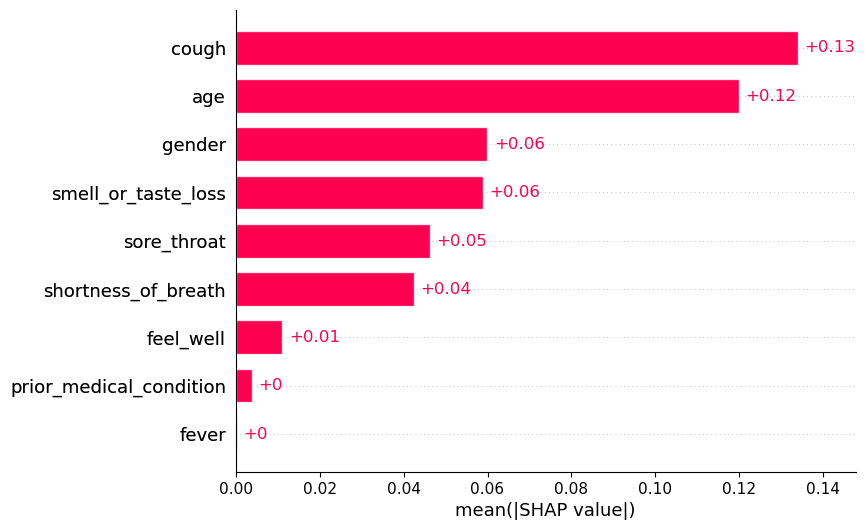

In [98]:
shap.plots.bar(shap_values)

How is the global importance of each feature calculated?

#### The global importance of each feature is the mean absolute value for that feature over all the given samples. Meaning, that for every feature, the mean of all |SHAP values| is calculated and plotted in the plot above.

Which symptom (not age) contributes most to the prediction?

#### Cough contributes the most to the prediction as a global feature (across all instances).

Plot a beeswarm plot of the SHAP values \
https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/beeswarm.html

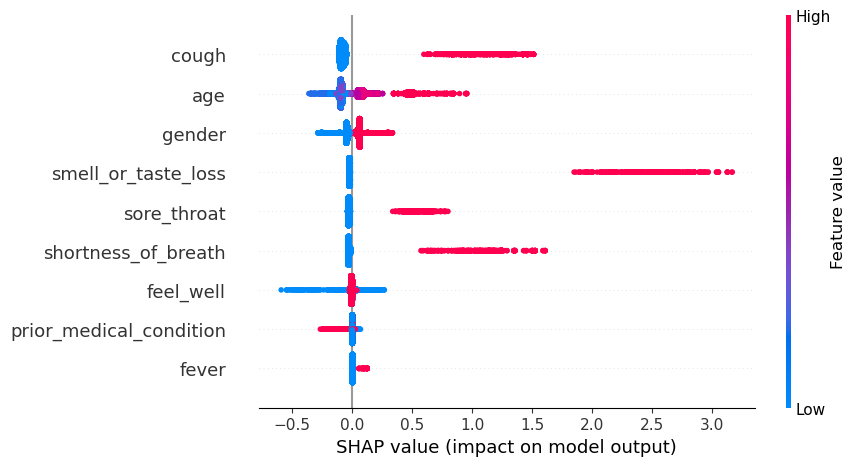

In [99]:
shap.plots.beeswarm(shap_values)

How is it different from the bar plot?

#### This plot shows the specific SHAP value **per sample** per feature, and the global contribution of each feature can be deduced by the order of the features to the left which is based on their averages. It is a more detailed representation of the bar plot, where we can see in more depth how the different features, with their values being high/low, contribute to the model's prediction.

What does each dot represent?

#### Each dot is a **different instance**, with its SHAP value.

What does the color of the dot represent?

#### The color represent the value of the feature per sample. It shows if the value of "Age" feature for example was lower/higher. By that we can deduce from the graph that being older in feature age, contributes to a positive model prediction.

Having which symptom contributes most to the prediction of being covid positive?

#### Having smell or taste loss contributes the most to being predicted as covid positive.

Does having a symptoms is as important for the prediction as not having it?

#### For the symptoms reported here, not having doesn't contribute to the prediction as having them. Having a symptom contributes much more to the prediction as seen by a bigger absolute SHAP value for high-value symptoms and vice versa.

Within a certain feature what does the vertical dispersion represent?

#### It represents instance's density. It shows how many samples had a certain SHAP value. 

How do we interpret the variability in SHAP values across instances and features, and what implications does it have for assessing the reliability of feature contributions to model predictions?

#### Variability in SHAP values reveals the consistency of a feature's contribution across different instances. High variability in SHAP values suggests that a feature’s impact is context-dependent, meaning it may only contribute significantly under certain conditions or in combination with other features. For instance, certain symptoms might show high SHAP values only when combined with other specific symptoms, indicating an interaction effect. On the other hand, low variability in SHAP values implies that the feature has a stable, reliable influence on predictions, regardless of context.

## Feature dependence

The XGBoost model we trained in the previous section is very complicated, but by plotting the SHAP value for a feature against the actual value of the feature for all instances we can see how changes in the feature’s value effect the model’s output. 

Note that this plot just explains how the XGBoost model works, not nessecarily how reality works. Since the XGBoost model is trained from observational data, it is not nessecarily a causal relationship.

Plot a shap dependence plot for age (use shap.dependence_plot but notice that in newer versions of shap and its documentation its called scatter)\
https://shap.readthedocs.io/en/latest/generated/shap.plots.scatter.html#shap.plots.scatter

In [100]:
# see the feature's names:
shap_values.feature_names

['age',
 'gender',
 'smell_or_taste_loss',
 'shortness_of_breath',
 'sore_throat',
 'cough',
 'fever',
 'feel_well',
 'prior_medical_condition']

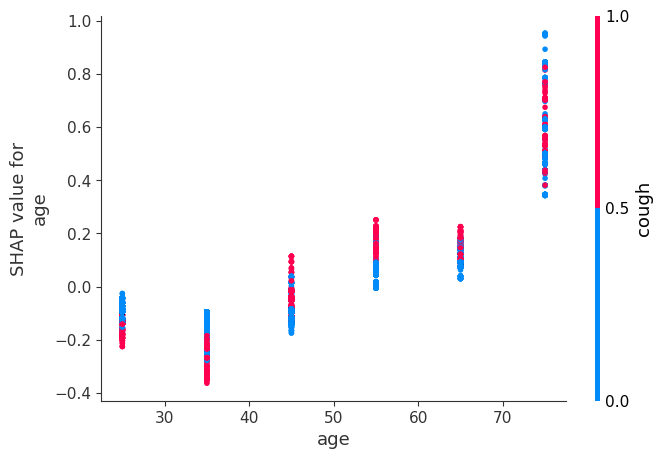

In [101]:
# Plot old version:
shap.dependence_plot("age", shap_values.values, X)

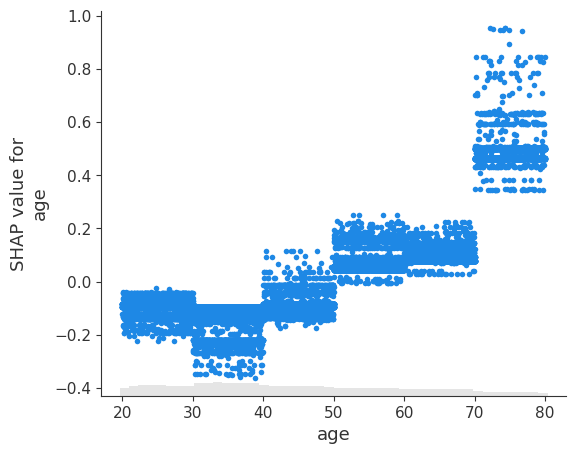

In [102]:
# Plot new version:
shap.plots.scatter(shap_values[:, "age"])

Which age group is the least likely to have covid according to the model?

#### Group age of 30-40 are less likely to have cobid according to the model.

What did the model learn about age?

#### That as people are above 50 they are more likely to have covid, while people under 50 are less likely to have covid. And more specifically, that people of ages 70-80 are with the highest likelyhood of having covid (being 70-80 contributes the most to the model's positive prediction), while people of ages 30-40 are the least likely to have covid (being 30-40 contributes well to the negative model prediction).

Plot the same shap dependence plot for age, but now color it by the symptom that contributes most to the prediction of being covid positive

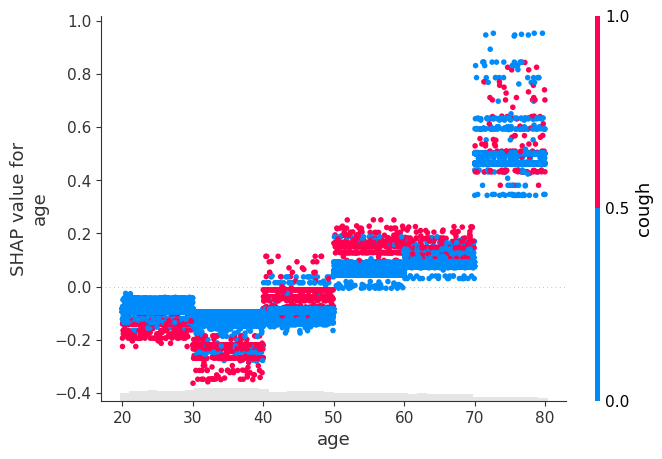

In [103]:
shap.plots.scatter(shap_values[:, "age"], shap_values)

These plots are not always easy to read, so plot it by yourself as a line plot

In [104]:
shap_values[:, "age"].values
X["age"]
X["cough"]

array([0.50097988, 0.1417674 , 0.04734323, ..., 0.1699242 , 0.13945154,
       0.06027262])

0        75
29075    65
29076    55
29077    45
29078    55
         ..
33819    45
10688    35
23138    65
7403     65
29393    55
Name: age, Length: 43752, dtype: int64

0        0.0
29075    0.0
29076    0.0
29077    0.0
29078    0.0
        ... 
33819    1.0
10688    0.0
23138    0.0
7403     0.0
29393    0.0
Name: cough, Length: 43752, dtype: float64

In [105]:
cough_age_data = {
    'age': X["age"],  # pandas Series for age
    'cough': X["cough"],  # pandas Series for cough
    'shap_value_age': shap_values[:, "age"].values  # numpy array of SHAP values for age
}
# Convert to DataFrame
df_cough_age = pd.DataFrame(cough_age_data)
df_cough_age

,age,cough,shap_value_age
0,75,0.0,0.500980
29075,65,0.0,0.141767
29076,55,0.0,0.047343
29077,45,0.0,-0.096093
29078,55,0.0,0.047343
...,...,...,...
33819,45,1.0,-0.011706
10688,35,0.0,-0.108459
23138,65,0.0,0.169924
7403,65,0.0,0.139452


In [106]:
# Group by age and cough values, calculate the mean of SHAP values
bins = [20, 30, 40, 50, 60, 70, 80]
labels = ['20-30', '30-40', '40-50', '50-60', '60-70', '70-80']
df_cough_age['age_group'] = pd.cut(df_cough_age['age'], bins=bins, labels=labels, right=False)

# Group by age_group and cough, then calculate the mean SHAP value
grouped_df = df_cough_age.groupby(['age_group', 'cough'])['shap_value_age'].mean().reset_index()

In [107]:
grouped_df

,age_group,cough,shap_value_age
0,20-30,0.0,-0.088930
1,20-30,1.0,-0.145720
2,30-40,0.0,-0.103777
3,30-40,1.0,-0.236247
4,40-50,0.0,-0.090832
5,40-50,1.0,-0.033609
6,50-60,0.0,0.054740
7,50-60,1.0,0.157684
8,60-70,0.0,0.086746
9,60-70,1.0,0.146755


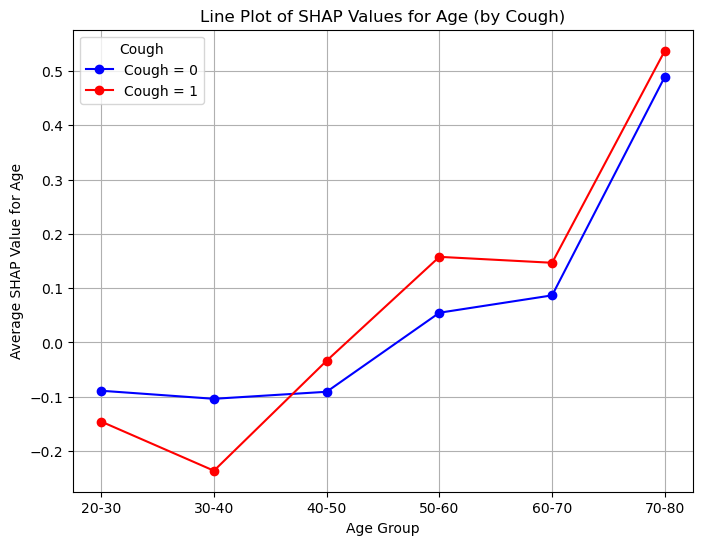

In [108]:
# Pivot the table to have separate columns for each cough value
pivot_df = grouped_df.pivot(index="age_group", columns="cough", values="shap_value_age")

# Plot the two lines in the same plot
plt.figure(figsize=(8, 6))
plt.plot(pivot_df.index, pivot_df[0.0], marker="o", label="Cough = 0", color="blue")
plt.plot(pivot_df.index, pivot_df[1.0], marker="o", label="Cough = 1", color="red")

# Add labels and title
plt.xlabel("Age Group")
plt.ylabel("Average SHAP Value for Age")
plt.title("Line Plot of SHAP Values for Age (by Cough)")
plt.legend(title="Cough")
plt.grid(True)
plt.show();

<Figure size 1000x600 with 0 Axes>

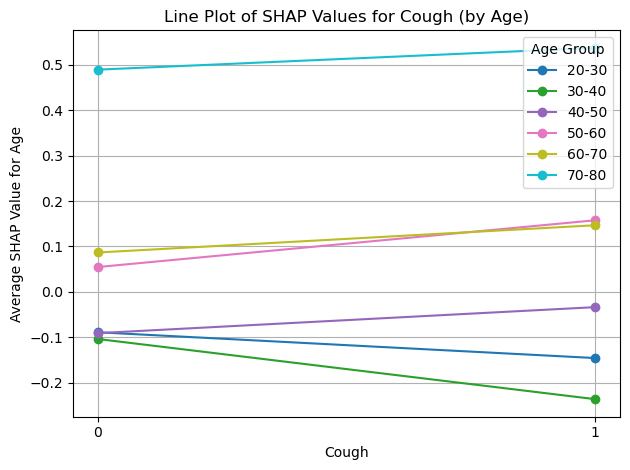

In [109]:
# Version 2: Pivot the table to have separate columns for each age value
pivoted_df = grouped_df.pivot(index='cough', columns='age_group', values='shap_value_age')

# Plot all columns at once. Each column represents a different age group
plt.figure(figsize=(10, 6))
pivoted_df.plot(marker='o', linestyle='-', cmap='tab10')

# add labels and title:
plt.xlabel("Cough")
plt.ylabel("Average SHAP Value for Age")
# Set x-ticks to 0 and 1 explicitly
plt.xticks(ticks=[0, 1], labels=['0', '1'])
plt.legend(title='Age Group', loc='upper right')
plt.title("Line Plot of SHAP Values for Cough (by Age)")
plt.grid(True)
plt.tight_layout()
plt.show();

How is the contribution of age depends on the symptom?

#### In younger ages the contribution depends more greatly on the symptom relative to older ages. As seen by the plots, in younger ages (under 50), having/not having a cough changes the age contribution more dramatically. Looking at the values of SHAP we can see that older ages on their own contribute a lot to the model's prediction and depends less on coughing.In summary, The contribution of age depends mostly on the symptom in younger ages.  

How would you validate the insights gained from SHAP dependence plots and ensure their robustness?

#### I would maybe try to train the model using cross validation (where I train the model on different subsets of data)/permutation test (where I shuffle the cough and age labels), seeing that this dependency presist and that it is meaningful in comparison to random noise.

# Features interaction

SHAP interaction values quantify the extent to which the relationship between two features affects the model's output. By examining these interaction values, we can uncover synergies or dependencies between features that may not be apparent when analyzing them in isolation.

Compute the SHAP interaction values using the TreeExplainer
https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Basic%20SHAP%20Interaction%20Value%20Example%20in%20XGBoost.html

In [110]:
# I need to use an explainer that alows it:
explainer = shap.TreeExplainer(model)
# This is because Explainer I used before assumes independent features.
shap_interaction_values = explainer.shap_interaction_values(X)

In [111]:
shap_interaction_values.shape

(43752, 9, 9)

In [112]:
# SHAP interaction values example:
pd.DataFrame(shap_interaction_values[0],index=X.columns,columns=X.columns)

,age,gender,smell_or_taste_loss,shortness_of_breath,sore_throat,cough,fever,feel_well,prior_medical_condition
age,0.449022,2.028645e-02,1.144817e-02,-4.779448e-03,-2.245335e-04,0.002559,2.837398e-06,-0.007638,2.591701e-04
gender,0.020286,-7.390509e-02,-3.365926e-03,-1.297202e-04,2.219148e-03,0.020775,-1.338049e-08,-0.000544,-6.588747e-04
smell_or_taste_loss,0.011448,-3.365921e-03,-1.453284e-01,-9.075888e-04,7.246835e-04,0.004103,-8.326024e-07,-0.002887,-3.129388e-03
shortness_of_breath,-0.004779,-1.297127e-04,-9.075925e-04,-2.855087e-02,2.561221e-04,0.000538,-4.203903e-07,-0.000546,-1.232437e-03
sore_throat,-0.000224,2.219148e-03,7.247031e-04,2.561193e-04,-3.135731e-02,0.002531,-6.657210e-07,-0.000480,7.924746e-04
cough,0.002559,2.077532e-02,4.103452e-03,5.383454e-04,2.530564e-03,-0.137520,-1.320012e-06,0.001177,-1.332994e-03
fever,0.000003,-1.303852e-08,-8.344650e-07,-4.190952e-07,-6.649643e-07,-0.000001,-1.805624e-04,0.000000,6.984919e-09
feel_well,-0.007638,-5.438607e-04,-2.887078e-03,-5.464796e-04,-4.804581e-04,0.001177,0.000000e+00,0.001656,8.060748e-05
prior_medical_condition,0.000259,-6.588772e-04,-3.129438e-03,-1.232436e-03,7.924736e-04,-0.001333,7.050403e-09,0.000081,8.904597e-03


Plot the SHAP interaction values for age and the most contributing symptom

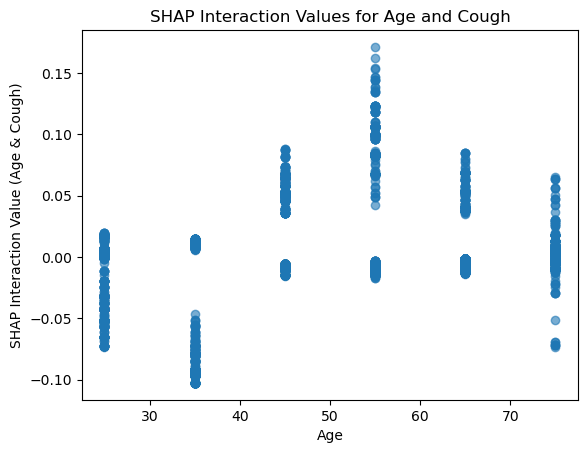

In [113]:
# Find the indices for "age" and "cough" features:
age_index = X.columns.get_loc("age")
cough_index = X.columns.get_loc("cough")

# Extract interaction values for the age-cough pair:
interaction_values_age_cough = shap_interaction_values[:, age_index, cough_index]

# Plot SHAP interaction values for age and cough
#plt.figure(figsize=(10, 6))
plt.scatter(X["age"], interaction_values_age_cough, alpha=0.6)
plt.xlabel("Age")
plt.ylabel("SHAP Interaction Value (Age & Cough)")
plt.title("SHAP Interaction Values for Age and Cough")
plt.show();

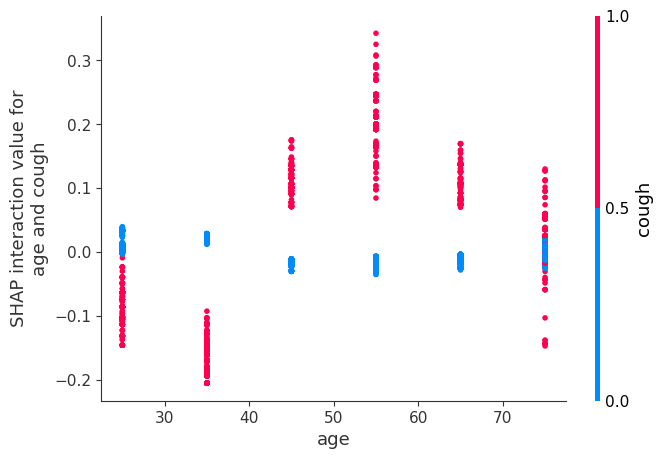

In [114]:
# Age-cough depenence plot (easier version, colors the interacting symptom):
shap.dependence_plot(
    ("age", "cough"),
    shap_interaction_values, X,
    display_features=X)

In the context of SHAP interaction values, what does a positive or negative value indicate for the relationship between two features? How can practitioners interpret and derive insights from these values in the context of model predictions?

#### Positive interaction means that combined presence of 2 features increases the model prediction more than if these features were considered independently while negative interaction indicate that their combination reduced the model's prediction more then when they were considered independently. In our case for example, the positive interaction around 50-60 suggests that cough is more impactful in older age groups and enhances the model’s prediction while the negative interaction around 30-40 suggests that cough has less significance or even interrupts with the prediction for younger individuals. In younger ages, cough and age are better predictors on their own.

Does the direction of effect of a feature (postive or negative SHAP value, not interaction value) depends on the other features in the model?

#### Yes. SHAP values capture the contribution of each feature to a particular prediction, considering the specific context of all other features in that instance. When SHAP values are computed for individual instances they are depended on the context of this instance feature's values. This is why they change between different instances, where the feature values differ.

# Summary

In this tutorial on SHapley Additive exPlanations, you have acquired an understanding of how to elucidate machine learning model outputs and interpret their decisions. SHAP, rooted in cooperative game theory, provides a systematic framework for distributing a model's prediction among its input features fairly, allowing for insightful analysis of feature importance and impact. By exploring SHAP values, feature dependence and interactions, you got practical tools to dissect model outputs, interpret positive and negative feature contributions, and uncover potential synergies between features. Enhancing your skills in model interpretability and deriving meaningful insights from complex predictive models.